# Data Preprocessing

## 1. Importing Libraries & Reading Data

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Making initial settins
pd.set_option('display.max_colwidth', None) # Display DataFrames columns in full width

In [2]:
df = pd.read_csv('data/s_telecom_customer_churn.csv')
df_dict = pd.read_csv('data/s_telecom_data_dictionary.csv', encoding='cp1252')

# 2. Inspecting Data

## 2.1 Viewing Data

In [3]:
df_dict.iloc[:,0:3]

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customer’s gender: Male, Female"
2,Customer Churn,Age,"The customer’s current age, in years, at the time the fiscal quarter ended (Q2 2022)"
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,"Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)"
5,Customer Churn,City,The city of the customer’s primary residence in California
6,Customer Churn,Zip Code,The zip code of the customer’s primary residence
7,Customer Churn,Latitude,The latitude of the customer’s primary residence
8,Customer Churn,Longitude,The longitude of the customer’s primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has referred a friend or family member to this company to date


In [4]:
df.shape

(7043, 38)

In [5]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [7]:
df.nunique()

Customer ID                          7043
Gender                                  2
Age                                    62
Married                                 2
Number of Dependents                   10
City                                 1106
Zip Code                             1626
Latitude                             1626
Longitude                            1625
Number of Referrals                    12
Tenure in Months                       72
Offer                                   5
Phone Service                           2
Avg Monthly Long Distance Charges    3583
Multiple Lines                          2
Internet Service                        2
Internet Type                           3
Avg Monthly GB Download                49
Online Security                         2
Online Backup                           2
Device Protection Plan                  2
Premium Tech Support                    2
Streaming TV                            2
Streaming Movies                  

In [8]:
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


## 2.2 Checking which columns/rows to drop and which to fix:
There are 38 columns which is a lot of features

### 2.2.1 Info vs Nunique vs Unique Values vs Nulls Percentage
Viweing info beside N-Unique values and unique values for better comparison and further inspection before final decision

In [9]:
def info_plus(df):
    '''
    Displays info() beside # Nulls, # Unique values, First 5 Unique values, and Nulls % 

    Args:
    df: DataFrame 
    
    Returns:
    info_plus_df: DataFrame of df.columns as rows and info() plus unique value info as columns
    '''
    info_plus = [[k, df[k].notnull().sum(), df[k].isnull().sum(), df[k].dtypes, df[k].nunique(),\
                  (df[k].unique().tolist()[:5]), int(df[k].isnull().sum()/len(df[k])*100)] for k in df.columns]
    info_plus_df = pd.DataFrame(info_plus, columns=['Column', 'Non-Null', 'Nulls', 'DType', 'N Unique',\
                                                    'First 5 Unique', '% Missing'])
    return info_plus_df

df_info = info_plus(df)
df_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Customer ID,7043,0,object,7043,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKFF, 0013-EXCHZ]",0
1,Gender,7043,0,object,2,"[Female, Male]",0
2,Age,7043,0,int64,62,"[37, 46, 50, 78, 75]",0
3,Married,7043,0,object,2,"[Yes, No]",0
4,Number of Dependents,7043,0,int64,10,"[0, 3, 1, 2, 4]",0
5,City,7043,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
6,Zip Code,7043,0,int64,1626,"[93225, 91206, 92627, 94553, 93010]",0
7,Latitude,7043,0,float64,1626,"[34.827662, 34.162515, 33.645672, 38.014457, 34.227846]",0
8,Longitude,7043,0,float64,1625,"[-118.999073, -118.203869, -117.922613, -122.115432, -119.079903]",0
9,Number of Referrals,7043,0,int64,12,"[2, 0, 1, 3, 8]",0


In [10]:
df_info[df_info['Nulls'] > 0]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
11,Offer,3166,3877,object,5,"[nan, Offer E, Offer D, Offer A, Offer B]",55
13,Avg Monthly Long Distance Charges,6361,682,float64,3583,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
14,Multiple Lines,6361,682,object,2,"[No, Yes, nan]",9
16,Internet Type,5517,1526,object,3,"[Cable, Fiber Optic, DSL, nan]",21
17,Avg Monthly GB Download,5517,1526,float64,49,"[16.0, 10.0, 30.0, 4.0, 11.0]",21
18,Online Security,5517,1526,object,2,"[No, Yes, nan]",21
19,Online Backup,5517,1526,object,2,"[Yes, No, nan]",21
20,Device Protection Plan,5517,1526,object,2,"[No, Yes, nan]",21
21,Premium Tech Support,5517,1526,object,2,"[Yes, No, nan]",21
22,Streaming TV,5517,1526,object,2,"[Yes, No, nan]",21


# 3. Cleaning Data

**Rows to Modify or Drop:**
1. Duplicated rows
2. Rows with missing values less than 5%
3. Rows or data entries not related to churn/not churn: Customer status "Joined" rows -> Drop rows if small % or turn into "Stayed" if more than 5%

## 3.1 Dopping Rows:

### 3.1.1 Drop Duplicates
**Findings**: No duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

### 3.1.2 Drop Missing Value rows
**Findings**: There are no variables with less than %5 to be dropped

### 3.1.3 Column - Customer Status: Replace "Joined" with "Stayed"

In [12]:
print(f'"Joined"% in Cusomer Status = %{(df["Customer Status"] == "Joined").sum().item()/df.shape[0]*100}')
print('Can either be ropped or changed to "Stayed"')

"Joined"% in Cusomer Status = %6.446116711628568
Can either be ropped or changed to "Stayed"


In [13]:
df2 = df.copy()

# for dropping "Joined" rows
df2 = df2[df2['Customer Status'] != 'Joined']

# for considering "Joined" row among "Stayed" rows
#df2 = df.copy()
# df2['Customer Status'] = df2['Customer Status'].str.replace('Joined','Stayed')

info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Customer ID,6589,0,object,6589,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKFF, 0013-EXCHZ]",0
1,Gender,6589,0,object,2,"[Female, Male]",0
2,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
3,Married,6589,0,object,2,"[Yes, No]",0
4,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
5,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
6,Zip Code,6589,0,int64,1626,"[93225, 91206, 92627, 94553, 93010]",0
7,Latitude,6589,0,float64,1626,"[34.827662, 34.162515, 33.645672, 38.014457, 34.227846]",0
8,Longitude,6589,0,float64,1625,"[-118.999073, -118.203869, -117.922613, -122.115432, -119.079903]",0
9,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0


## 3.4 Drop Columns
**Findings**: Columns/Rows to Modify or Drop:
1. Drop irrelevant columns:
    - Customer ID
    - Online Security
    - Online Backup
    - Paperless Billing
    - Payment Method
2. Columns with too many unique values and can't be categorized:
    - Latitude, Longitude, Zip Code -> Drop
    - City (vital) -> Keep
3. Columns with too many missing values (over %50 Nulls):
   - Offers -> Drop
   - Churn Category -> Drop
   - Churn Reason -> Drop
4. Related columns (highly correlated): Monthly charge, total charges -> Drop 1
5. Related columns (highly correlated): total refunds, total extra data charges, total long distance charges, total revenue -> Drop some
6. Related columns (highly correlated): Average Monthly Long Distance Charges, Total Long Distance Charges -> Drop 1

7. Columns that can be combined: Streaming TV, Streaming Movies, Streaming Music -> Merge

### 3.4.1 Columns: Customer ID, Latitude, Longitude, Zip Code, Offers, Churn Category, Churn Reason  

In [14]:
df2.drop(['Customer ID', 'Online Security', 'Online Backup', 'Paperless Billing', 'Payment Method', 'Longitude',\
          'Latitude', 'Zip Code', 'Offer', 'Churn Category', 'Churn Reason'], axis=1, inplace=True)

In [15]:
info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6589,0,object,2,"[Female, Male]",0
1,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,6589,0,object,2,"[Yes, No]",0
3,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,6589,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,6589,0,object,2,"[Yes, No]",0
8,Avg Monthly Long Distance Charges,5945,644,float64,3451,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
9,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9


### 3.4.2 Columns: Monthly Charge, Total Charges
**Findings**: 
- From the table below, Total Charges column values are almost equal to Monthly Charges Multiplied by Tenure in Months (except for the rows with outlier Monthly Charges)
- Hence, we'll keep one of them. And since the rest all financial charges are calculated till last quarter, we'll drop the Monthly Charge column.
- Another reason to remove the Montly Charge column is that it has outliers while the Total Charges column doesn't.

In [16]:
df2['Total / (Tenure x Monthly)'] = df2['Total Charges'] / df2['Tenure in Months'] / df2['Monthly Charge']
df2[['Tenure in Months','Monthly Charge', 'Total Charges', 'Total / (Tenure x Monthly)']].head(10)
#info_plus(df)

,Tenure in Months,Monthly Charge,Total Charges,Total / (Tenure x Monthly)
0,9,65.60,593.30,1.004912
1,9,-4.00,542.40,-15.066667
2,4,73.90,280.85,0.950101
3,13,98.00,1237.85,0.971625
4,3,83.90,267.40,1.062376
5,9,69.40,571.45,0.914906
6,71,109.70,7904.25,1.014836
7,63,84.65,5377.80,1.008410
8,7,48.20,340.35,1.008743
9,65,90.45,5957.90,1.013378


To have a more comprehensive view, lets get the stats for the columns above

In [17]:
df2[['Tenure in Months','Monthly Charge', 'Total Charges', 'Total / (Tenure x Monthly)']].describe()

,Tenure in Months,Monthly Charge,Total Charges,Total / (Tenure x Monthly)
count,6589.000000,6589.000000,6589.000000,6589.000000
mean,34.499772,65.030695,2432.042243,0.633338
std,23.968734,31.100727,2265.500080,4.142647
min,1.000000,-10.000000,18.850000,-99.658333
25%,12.000000,35.800000,544.550000,0.977937
50%,32.000000,71.050000,1563.900000,1.000000
75%,57.000000,90.400000,4003.000000,1.019384
max,72.000000,118.750000,8684.800000,1.494924


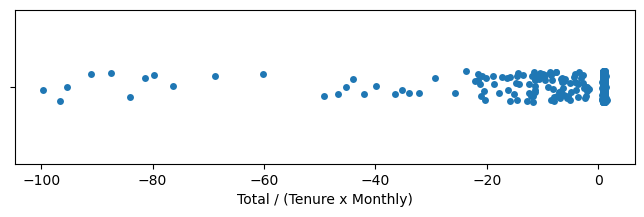

In [18]:
plt.figure(figsize=(8,2))
sns.stripplot(data=df2['Total / (Tenure x Monthly)'], orient='h');

In [19]:
perc = len(df2[(df2['Total / (Tenure x Monthly)'] > 0.95) & (df2['Total / (Tenure x Monthly)'] < 1.05)])/len(df2) * 100
print(f'The percentage of values in the Total / (Tenure x Monthly) column that\'s between 0.95 & 1.05 is {perc}')

The percentage of values in the Total / (Tenure x Monthly) column that's between 0.95 & 1.05 is 79.95143420852938


**Findings**: 
- The Total/(Tenure x Month) column has a mean is 0.63, this is because of the outliers
- The median is 1.00 because it isn't influenced by outliers as much.
- Inspite of outlier's presence, we find that 50% of values are approximately 1.0 (between Q1 & Q3)
- %80 of the column values fall between 0.95 and 1.05, and the rest 20% are the negative outliers of Monthly Charge column which are the scattered points in the negative range.
- We will remove the Montly Charge column since it can be calculated using the other 2 columns if needed. Another reason to remove it is that because it is monthly and the rest of the charges are totals till quarter.
- So, we will drop the Monthly Charge Column

In [20]:
df2.drop(['Monthly Charge', 'Total / (Tenure x Monthly)'], axis=1, inplace=True)
df2.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status'],
      dtype='object')

### 3.4.3 Columns:Total refunds, Total extra data charges, Total long distance charges, Total Revenue
**Findings**: 
- From the Dicionary csv file (displayed at the beginning of the notebook): <br>
**Total Revenue = Total Charges - Total Refunds + Total Extra Data Charges + Total Long Distance Charges**
- To avoid multicollinearity, So we can remove total revenue or the other 4 values.
- However, since charges can be of great significance in a client's churn decision, we'll remove the Total Revenue column and keep the other 4.

In [21]:
df2.drop('Total Revenue', axis=1, inplace=True)
info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6589,0,object,2,"[Female, Male]",0
1,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,6589,0,object,2,"[Yes, No]",0
3,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,6589,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,6589,0,object,2,"[Yes, No]",0
8,Avg Monthly Long Distance Charges,5945,644,float64,3451,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
9,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9


In [22]:
# df2[['Tenure in Months','Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges',\
     # 'Total Long Distance Charges', 'Total Revenue', 'Avg Monthly Long Distance Charges']].head(10)
info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6589,0,object,2,"[Female, Male]",0
1,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,6589,0,object,2,"[Yes, No]",0
3,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,6589,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,6589,0,object,2,"[Yes, No]",0
8,Avg Monthly Long Distance Charges,5945,644,float64,3451,"[42.39, 10.69, 33.65, 27.82, 7.38]",9
9,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9


### 3.4.4 Columns: Average Monthly Long Distance Charges, Total Long Distance Charges
**Findings**: 
- The Avg Monthly Long Distance Charges and the Total Long Distance Charges columsn can be calculated from each other directly.
- So we will drop one of them to avoid multicollinearity.

In [23]:
df2['Total / (Tenure x Monthly)'] = df2['Total Long Distance Charges'] / df2['Tenure in Months'] / \
                                    df2['Avg Monthly Long Distance Charges']
df2[['Tenure in Months', 'Avg Monthly Long Distance Charges', 'Total Long Distance Charges', \
'Total / (Tenure x Monthly)']].head()

,Tenure in Months,Avg Monthly Long Distance Charges,Total Long Distance Charges,Total / (Tenure x Monthly)
0,9,42.39,381.51,1.0
1,9,10.69,96.21,1.0
2,4,33.65,134.60,1.0
3,13,27.82,361.66,1.0
4,3,7.38,22.14,1.0


**Findings**: 
- Similar to the previous section, the Avg Monthly Long Distance Charges and the Total Long Distance Charges columsn can be calculated from each other directly.
- So we will drop one of them to avoid multicollinearity.
- We chose to drop the Avg Monthly Long Distance Charges for two reasons:
  1. It has 9 missing values while the Total Long Distance Charges column doesn't have any.
  2. The Total Long Distance Charges column has already been chosen for keep in the previous section.


In [24]:
df2.drop(['Avg Monthly Long Distance Charges', 'Total / (Tenure x Monthly)'], axis=1, inplace=True)
info_plus(df2)

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6589,0,object,2,"[Female, Male]",0
1,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,6589,0,object,2,"[Yes, No]",0
3,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,6589,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,6589,0,object,2,"[Yes, No]",0
8,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9
9,Internet Service,6589,0,object,2,"[Yes, No]",0


### 3.4.5 Columns: Streaming TV, Streaming Movies, Streaming Music
**Findings**: 
- Since these 3 columns are related, we will combine them as a column called 'Streaming Services', which take values of 0 -> 4 depending on the number of services the client applied for.
- We will do this after we fill in the missing values since each of them has a 1344 missing values.

Checking if the 1344 (%20) nulls appear in the same rows for the 3 streaming columns

In [25]:
len(df2[df2['Streaming TV'].isnull() & df2['Streaming Movies'].isnull() & df2['Streaming Music'].isnull()])

1344

## 3.5 Handling Missing Values

In [26]:
# List of columns with missing values
info_plus(df2)[(info_plus(df2)['Nulls'] > 0)]

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
8,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9
10,Internet Type,5245,1344,object,3,"[Cable, Fiber Optic, DSL, nan]",20
11,Avg Monthly GB Download,5245,1344,float64,49,"[16.0, 10.0, 30.0, 4.0, 11.0]",20
12,Device Protection Plan,5245,1344,object,2,"[No, Yes, nan]",20
13,Premium Tech Support,5245,1344,object,2,"[Yes, No, nan]",20
14,Streaming TV,5245,1344,object,2,"[Yes, No, nan]",20
15,Streaming Movies,5245,1344,object,2,"[No, Yes, nan]",20
16,Streaming Music,5245,1344,object,2,"[No, Yes, nan]",20
17,Unlimited Data,5245,1344,object,2,"[Yes, No, nan]",20


### 3.5.1 Handling Missing Values of Numerical Columns
1. We'll check numerical columns with missing values for outliers.
2. We'll fill the missing values according to our findings. <br>

**Findings:**: 
- Since Avg Monthly GB Download column has outliers, we'll fill the missing values with the median rather than the median
- As for the categorical columns, we'll fill the missing values with the mode.

#### 3.5.1.1 Checking Numerical Columns with Missing Values for Outliers

In [27]:
# Numerical Columns with Nulls
num_null_cols_info = info_plus(df2)[(info_plus(df2)['Nulls'] > 0) & ((info_plus(df2)['DType'] == 'float64')\
                                                                 | (info_plus(df2)['DType'] == 'int64'))]
num_null_cols_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
11,Avg Monthly GB Download,5245,1344,float64,49,"[16.0, 10.0, 30.0, 4.0, 11.0]",20


In [28]:
#df2[num_null_cols[11]].describe()
df2[num_null_cols_info.iloc[0,0]].describe()

count    5245.000000
mean       26.225929
std        19.565724
min         2.000000
25%        13.000000
50%        21.000000
75%        30.000000
max        85.000000
Name: Avg Monthly GB Download, dtype: float64

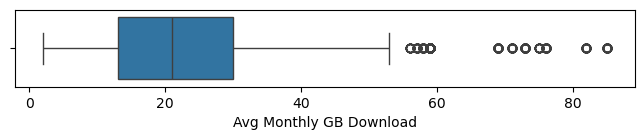

In [29]:
plt.figure(figsize=(8,1))
sns.boxplot(data=df2['Avg Monthly GB Download'], orient='h');

**Findings**: Since Avg Monthly GB Download column has outliers, we'll fill the missing values with the median rather than the median

#### 3.5.1.2 Filling Numerical Columns Nulls
Since the missing values constitute %20 of the column, we will fill the missing values with the median instead of dropping them.

In [30]:
df2['Avg Monthly GB Download'] = df2['Avg Monthly GB Download'].fillna(df2['Avg Monthly GB Download'].median())
df2['Avg Monthly GB Download'].isnull().sum()

np.int64(0)

### 3.5.2 Handling Missing Values of Categorical Columns
We will fill the categorical values missing values using the mode. 

In [31]:
cat_null_cols_info = info_plus(df2)[(info_plus(df2)['Nulls'] > 0) & (info_plus(df2)['DType'] == 'object')]
cat_null_cols_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
8,Multiple Lines,5945,644,object,2,"[No, Yes, nan]",9
10,Internet Type,5245,1344,object,3,"[Cable, Fiber Optic, DSL, nan]",20
12,Device Protection Plan,5245,1344,object,2,"[No, Yes, nan]",20
13,Premium Tech Support,5245,1344,object,2,"[Yes, No, nan]",20
14,Streaming TV,5245,1344,object,2,"[Yes, No, nan]",20
15,Streaming Movies,5245,1344,object,2,"[No, Yes, nan]",20
16,Streaming Music,5245,1344,object,2,"[No, Yes, nan]",20
17,Unlimited Data,5245,1344,object,2,"[Yes, No, nan]",20


In [32]:
df2[cat_null_cols_info.iloc[:,0]].describe()

,Multiple Lines,Internet Type,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data
count,5945,5245,5245,5245,5245,5245,5245,5245
unique,2,3,2,2,2,2,2,2
top,No,Fiber Optic,No,No,Yes,Yes,No,Yes
freq,3019,2934,2855,3248,2658,2683,2809,4521


In [45]:
# Data Series of categorical columns with Nulls
nan_cols = cat_null_cols_info.iloc[:,0]

# Filling missing values with mode of columns (most frequent value)
df2[nan_cols] = df2[nan_cols].fillna(df2[nan_cols].mode().iloc[0])

info_plus(df2)

# testing outputs:
#df2[nan_cols].mode()[0]
#df2['nan_cols']
#print(df2[nan_cols].mode().iloc[0])

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing
0,Gender,6589,0,object,2,"[Female, Male]",0
1,Age,6589,0,int64,62,"[37, 46, 50, 78, 75]",0
2,Married,6589,0,object,2,"[Yes, No]",0
3,Number of Dependents,6589,0,int64,10,"[0, 3, 1, 2, 4]",0
4,City,6589,0,object,1106,"[Frazier Park, Glendale, Costa Mesa, Martinez, Camarillo]",0
5,Number of Referrals,6589,0,int64,12,"[2, 0, 1, 3, 8]",0
6,Tenure in Months,6589,0,int64,72,"[9, 4, 13, 3, 71]",0
7,Phone Service,6589,0,object,2,"[Yes, No]",0
8,Multiple Lines,6589,0,object,2,"[No, Yes]",0
9,Internet Service,6589,0,object,2,"[Yes, No]",0


**Findings:** All missing values have been filled

## 3.6 Handling Outliers:
**Findings:** We separate numerical columns into two categories for two boxplots (Small values & Large Value categories) to get a more descriptive view.
- From small value columns BoxPlot: Age, Number of Dependants, and Tenure in Months columns seem to have no outliers. 
- Although the small values boxplot shows outliers in Number of Referrals columns, from the stats description the maximum value in that column is 11 which is reasonable. So, no outliers here as well.
- The BoxPlots shows that Avg Monthly GB Download and Total Extra Data Charges columns have outliers. However, these values are also resonable:
    1. For Total Extra Data Charges column: Older subuscribers (high Tenure in Months values) have more total (cummulative) for their services.
    2. For Avg Monthly GB Download: These are average monthly values which has no relation to how old the customer subscription. But it also can be explained as some users have excessive internet usage compared to others.



### 3.6.1 Detecting Outliers

In [38]:
df2.describe()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly GB Download,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges
count,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000
mean,46.760510,0.476097,2.020944,34.499772,25.159964,2432.042243,2.080938,7.169525,798.087251
std,16.841362,0.968499,3.024016,23.968734,17.582805,2265.500080,8.125054,25.803163,853.767972
min,19.000000,0.000000,0.000000,1.000000,2.000000,18.850000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,0.000000,12.000000,15.000000,544.550000,0.000000,0.000000,106.680000
50%,46.000000,0.000000,0.000000,32.000000,21.000000,1563.900000,0.000000,0.000000,472.680000
75%,60.000000,0.000000,3.000000,57.000000,27.000000,4003.000000,0.000000,0.000000,1275.120000
max,80.000000,9.000000,11.000000,72.000000,85.000000,8684.800000,49.790000,150.000000,3564.720000


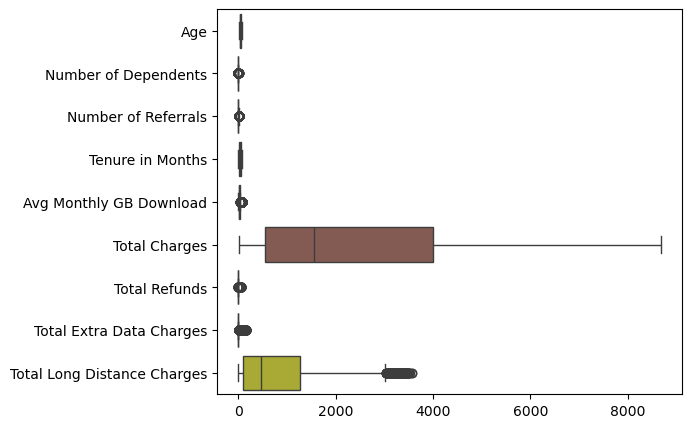

In [52]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df2, orient='h');

### 3.6.2 Separate Columns into Two Categories: Small Values & Large Values
 After Splitting the columns into two groups, we make a boxplot for each group individually

In [39]:
# selecting only numerical columns for boxplot
df_num_cols = df2.select_dtypes(include='number')

# create the two numerical columns groups
cols = list(df_num_cols.columns)
cols_small = cols[0:5] + cols[6:8]
cols_large = [cols[5], cols[8]]
print('Small values columns are:\n',cols_small)
print('Large values columns are:\n',cols_large)

Small values columns are:
 ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly GB Download', 'Total Refunds', 'Total Extra Data Charges']
Large values columns are:
 ['Total Charges', 'Total Long Distance Charges']


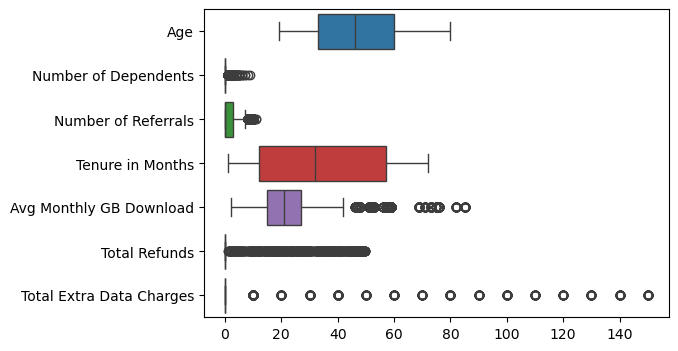

In [54]:
# Small Value Data Columns Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=df2[cols_small], orient='h');

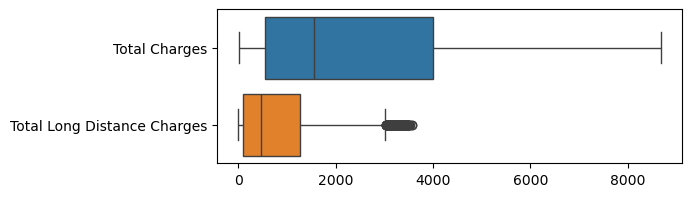

In [55]:
# Large Value Data Columns Boxplot
plt.figure(figsize=(6,2))
sns.boxplot(data=df2[cols_large], orient='h');

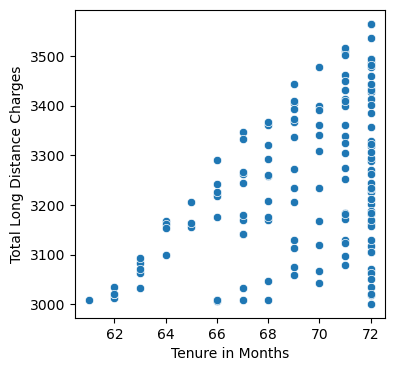

In [56]:
# Checking subscription periods for higher (outlier-like) Total Long Distance Charges values
df2_months_charges = df2.loc[df2['Total Long Distance Charges'] >= 3000, \
                     ['Tenure in Months', 'Total Long Distance Charges']]
plt.figure(figsize=(4,4))
sns.scatterplot(data=df2, x=df2_months_charges['Tenure in Months'], y=df2_months_charges['Total Long Distance Charges']);

**Findings**: This scatterplot shows that the Total Long Distance Charges column outliers correspond to high Tenure in Months column values, i.e older subscribers. Hence these are not actually outliers.

In [43]:
num_null_cols_info = info_plus(df2)[(info_plus(df2)['Nulls'] > 0) & (info_plus(df2)['DType'] == 'float64')]
num_null_cols_info

,Column,Non-Null,Nulls,DType,N Unique,First 5 Unique,% Missing


In [44]:
#df2[num_null_cols[11]].describe()
df2[num_null_cols_info.iloc[0,0]].describe()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
cat_null_cols_info = info_plus(df2)[(info_plus(df2)['Nulls'] > 0) & (info_plus(df2)['DType'] == 'object')]
cat_null_cols_info

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
sns.boxplot(data=df2[cols_small in ], orient='h', ax=axs[0]);


# 5. Feature Engineering

- Since all the 3 column nulls appear in the same rows simultaneously, we can combine the 3 columns now and fill in the missing value for the newely created 'Streaming Services Column' later.

In [ ]:
df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']] = \
df2[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda x: x.map({'Yes':1, 'No':0}))
# df2['Streaming TV'] = df2['Streaming TV'].map({'Yes':1, 'No':0})
# df2['Streaming Movies'] = df2['Streaming Movies'].map({'Yes':1, 'No':0})
# df2['Streaming Music'] = df2['Streaming Music'].map({'Yes':1, 'No':0})
df2['# Streaming Services'] = df2['Streaming TV'] + df2['Streaming Movies'] + df2['Streaming Music']
info_plus(df2)